# Default Setting

Executed in Colab pro environment.

* ML Framework
   - Python 3.7.10
   - Tensorflow 2.5.0

* Hardware
   - RAM: 12.7G 
   - CPU: Intel(R) Xeon(R) CPU @ 2.30GHz (1core)
   - GPU: Tesla P100-PCIE-16GB

# 0. import packages

In [1]:
# 빗썸 가상화폐 데이터 모듈
!pip install -q pybithumb

In [2]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import pybithumb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

# 2. Data Preprocessing

In [3]:
mydf = pybithumb.get_ohlcv("ETH",interval='hour').reset_index()

In [4]:
mydf.head()

,time,open,high,low,close,volume
0,2020-11-30 21:00:00,643000.0,651000.0,643000.0,651000.0,6306.955222
1,2020-11-30 22:00:00,651500.0,657000.0,647000.0,653500.0,6637.429368
2,2020-11-30 23:00:00,653500.0,660000.0,646500.0,648000.0,10275.021635
3,2020-12-01 00:00:00,649000.0,654500.0,644500.0,646000.0,8321.061685
4,2020-12-01 01:00:00,645500.0,660000.0,645500.0,650500.0,5272.889987


In [5]:
plt.rcParams["figure.figsize"] = (15,10)

Text(0.5, 1.0, 'ETH')

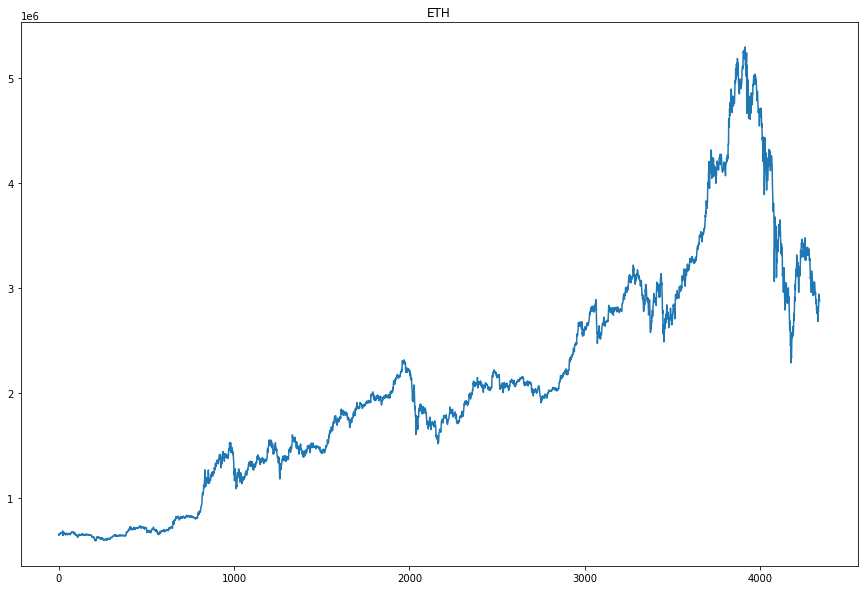

In [6]:
plt.plot(mydf['open'])
plt.title('ETH')

In [7]:
def preprocess(series, window_size=None, scaling=True):

    if window_size!=None:
        series = series.rolling(window_size, min_periods=0).mean()
    array = np.array(series)
    
    if scaling==True:
        scaler = MinMaxScaler()
        training_data = scaler.fit_transform(array.reshape(-1,1))
    else:
        scaler = None

    return training_data, scaler

In [8]:
def make_dataset(training_data, t, h=0, test_size=0.2):
    
    X_train = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t:i])
        y_train.append(training_data[i+h])
    X = np.array(X_train)
    y = np.array(y_train)

    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train,X_test,y_train,y_test

In [9]:
training_data, scaler = preprocess(mydf['open'], window_size=10)

In [10]:
X_train,X_test,y_train,y_test = make_dataset(training_data, t = 168)

# MAE, MSE, RMSE

In [11]:
def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))

# GRU-adaboost FIT

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# adaboost
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=5, random_state=42)

In [15]:
final_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
112/112 [==============================] - 4s 9ms/step - loss: 0.0055
Epoch 2/20
112/112 [==============================] - 1s 8ms/step - loss: 9.2590e-04
Epoch 3/20
112/112 [==============================] - 1s 8ms/step - loss: 7.9299e-04
Epoch 4/20
112/112 [==============================] - 1s 8ms/step - loss: 6.9253e-04
Epoch 5/20
112/112 [==============================] - 1s 8ms/step - loss: 6.3085e-04
Epoch 6/20
112/112 [==============================] - 1s 8ms/step - loss: 6.1664e-04
Epoch 7/20
112/112 [==============================] - 1s 8ms/step - loss: 5.5611e-04
Epoch 8/20
112/112 [==============================] - 1s 8ms/step - loss: 5.1749e-04
Epoch 9/20
112/112 [==============================] - 1s 8ms/step - loss: 4.7786e-04
Epoch 10/20
112/112 [==============================] - 1s 9ms/step - loss: 4.3924e-04
Epoch 11/20
112/112 [==============================] - 1s 9ms/step - loss: 4.4698e-04
Epoch 12/20
112/112 [==============================] - 1s 9ms/step 

AdaBoostRegressor(base_estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f02400a9490>,
                  learning_rate=1.0, loss='linear', n_estimators=5,
                  random_state=42)

In [16]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

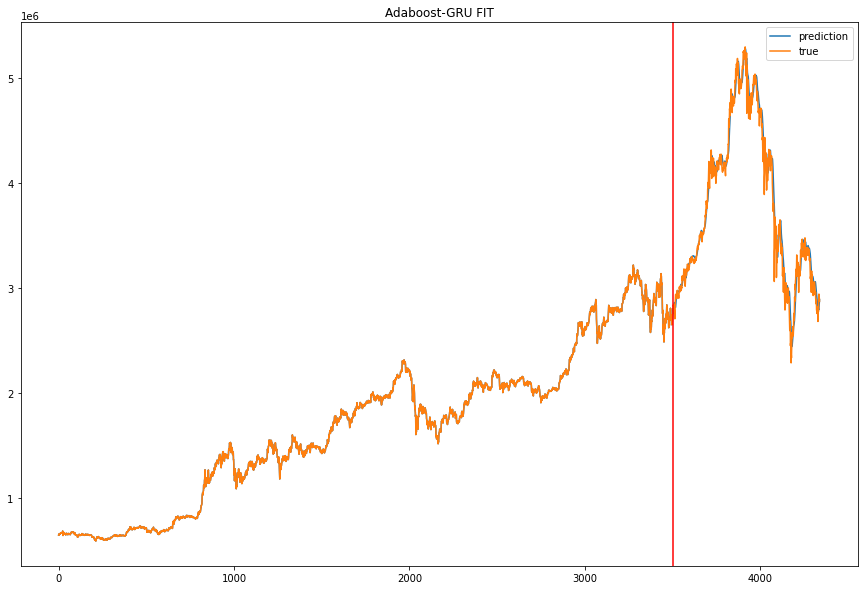

In [17]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-GRU FIT')
plt.show()

In [18]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [19]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

7.92e+04
1.23e+10
1.11e+05


# LSTM-adaboost FIT

In [20]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
LSTM_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(LSTM_Predictors, n_estimators=5, random_state=42)

In [23]:
final_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
112/112 [==============================] - 3s 10ms/step - loss: 0.0040
Epoch 2/20
112/112 [==============================] - 1s 10ms/step - loss: 9.5776e-04
Epoch 3/20
112/112 [==============================] - 1s 10ms/step - loss: 7.7908e-04
Epoch 4/20
112/112 [==============================] - 1s 10ms/step - loss: 7.6283e-04
Epoch 5/20
112/112 [==============================] - 1s 10ms/step - loss: 6.4653e-04
Epoch 6/20
112/112 [==============================] - 1s 10ms/step - loss: 5.8055e-04
Epoch 7/20
112/112 [==============================] - 1s 10ms/step - loss: 4.9498e-04
Epoch 8/20
112/112 [==============================] - 1s 10ms/step - loss: 4.9507e-04
Epoch 9/20
112/112 [==============================] - 1s 10ms/step - loss: 4.2566e-04
Epoch 10/20
112/112 [==============================] - 1s 10ms/step - loss: 4.4694e-04
Epoch 11/20
112/112 [==============================] - 1s 10ms/step - loss: 4.0940e-04
Epoch 12/20
112/112 [==============================] - 1

AdaBoostRegressor(base_estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f01d0246ad0>,
                  learning_rate=1.0, loss='linear', n_estimators=5,
                  random_state=42)

In [24]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

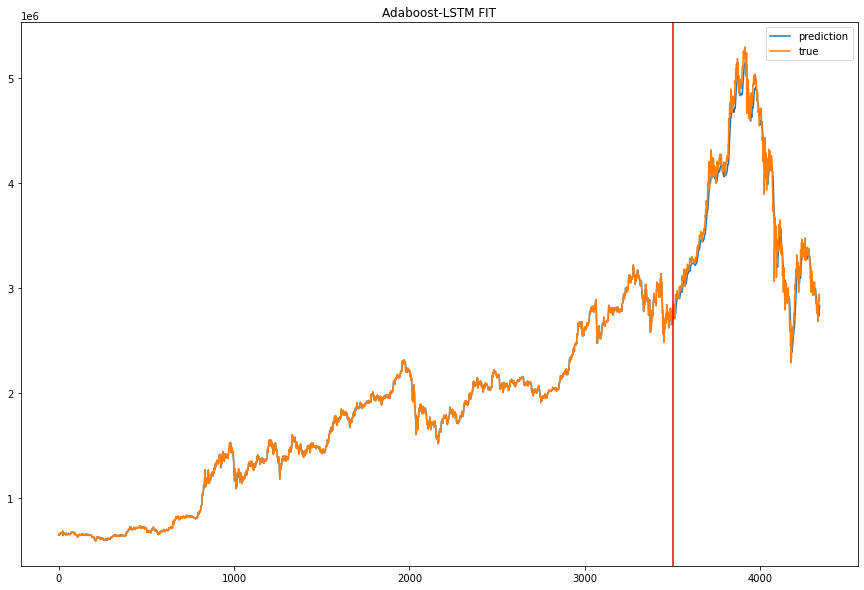

In [25]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-LSTM FIT')
plt.show()

In [26]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [27]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

9.76e+04
1.49e+10
1.22e+05


# GRU Fit

In [28]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
model.fit(X_train,y_train,batch_size=30,epochs=20,validation_split=0.2)

Epoch 1/20
89/89 [==============================] - 3s 14ms/step - loss: 0.0031 - val_loss: 1.9511e-04
Epoch 2/20
89/89 [==============================] - 1s 10ms/step - loss: 6.0257e-04 - val_loss: 2.2880e-04
Epoch 3/20
89/89 [==============================] - 1s 10ms/step - loss: 5.0351e-04 - val_loss: 9.7975e-05
Epoch 4/20
89/89 [==============================] - 1s 10ms/step - loss: 4.5455e-04 - val_loss: 8.7406e-05
Epoch 5/20
89/89 [==============================] - 1s 10ms/step - loss: 4.0057e-04 - val_loss: 1.5397e-04
Epoch 6/20
89/89 [==============================] - 1s 10ms/step - loss: 3.5338e-04 - val_loss: 1.6214e-05
Epoch 7/20
89/89 [==============================] - 1s 10ms/step - loss: 3.2508e-04 - val_loss: 5.8658e-05
Epoch 8/20
89/89 [==============================] - 1s 10ms/step - loss: 2.9006e-04 - val_loss: 1.2104e-04
Epoch 9/20
89/89 [==============================] - 1s 10ms/step - loss: 2.5875e-04 - val_loss: 1.3339e-04
Epoch 10/20
89/89 [======================

In [31]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

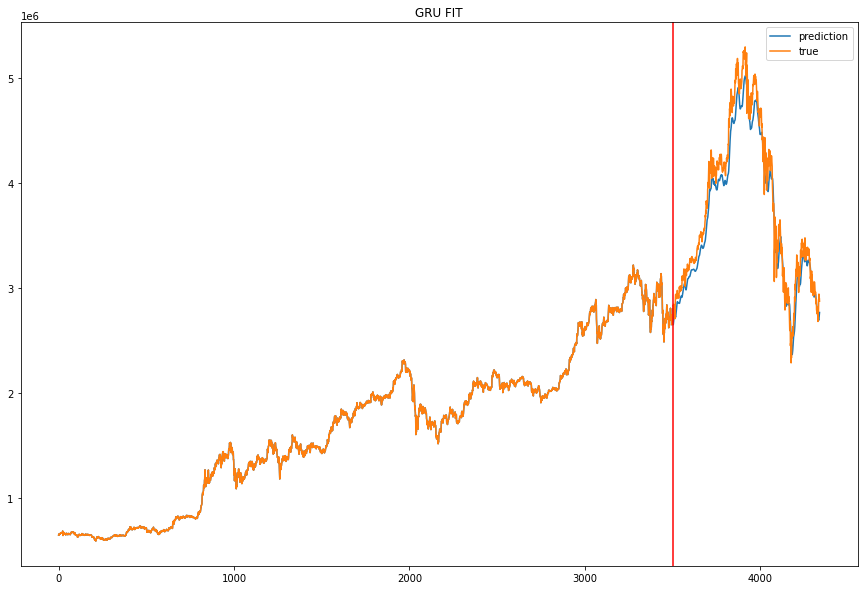

In [32]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('GRU FIT')
plt.show()

In [33]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [34]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

1.50e+05
3.06e+10
1.75e+05


# LSTM FIT

In [35]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [36]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [37]:
model.fit(X_train,y_train,batch_size=30,epochs=20,validation_split=0.2)

Epoch 1/20
89/89 [==============================] - 3s 16ms/step - loss: 0.0028 - val_loss: 2.6911e-04
Epoch 2/20
89/89 [==============================] - 1s 12ms/step - loss: 5.7852e-04 - val_loss: 6.3622e-04
Epoch 3/20
89/89 [==============================] - 1s 12ms/step - loss: 4.9562e-04 - val_loss: 1.3297e-04
Epoch 4/20
89/89 [==============================] - 1s 12ms/step - loss: 4.6960e-04 - val_loss: 1.3676e-04
Epoch 5/20
89/89 [==============================] - 1s 12ms/step - loss: 3.8529e-04 - val_loss: 2.9760e-04
Epoch 6/20
89/89 [==============================] - 1s 12ms/step - loss: 3.9958e-04 - val_loss: 1.7862e-04
Epoch 7/20
89/89 [==============================] - 1s 12ms/step - loss: 3.5736e-04 - val_loss: 7.6680e-05
Epoch 8/20
89/89 [==============================] - 1s 12ms/step - loss: 3.2584e-04 - val_loss: 1.1203e-04
Epoch 9/20
89/89 [==============================] - 1s 11ms/step - loss: 2.8554e-04 - val_loss: 1.4200e-04
Epoch 10/20
89/89 [======================

In [38]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

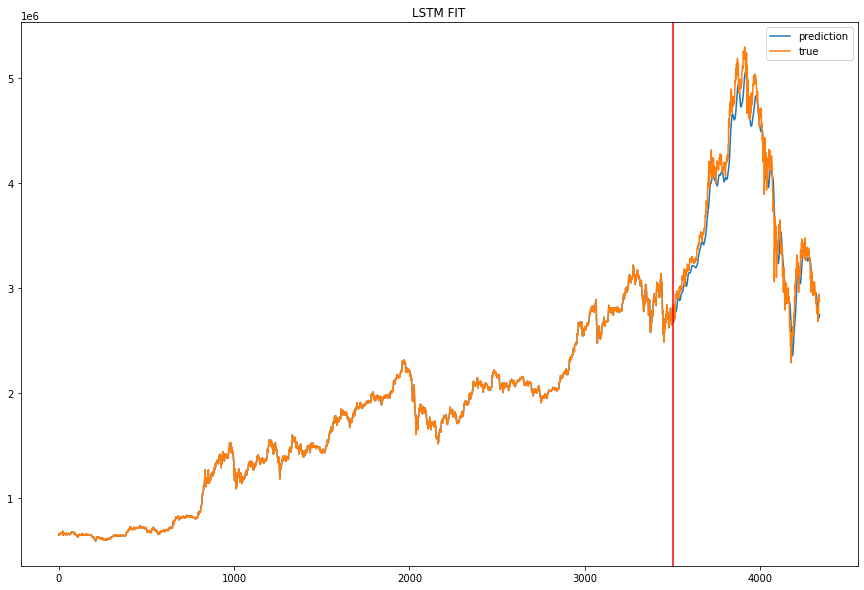

In [39]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('LSTM FIT')
plt.show()

In [40]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [41]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

1.36e+05
2.75e+10
1.66e+05
